<b>Übungsblatt</b>

In [1]:
bild1 = []
bild1.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])
bild1.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, -1, -1, -1, -1, -1, 1, -1])
bild1.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild1.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])

In [2]:
bild1

[[-1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1]]

In [3]:
bild2 = []
bild2.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, -1, 1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, -1, 1, -1, -1, -1, -1])
bild2.append([-1, -1, -1, 1, -1, 1, -1, -1, -1])
bild2.append([-1, -1, -1, 1, -1, 1, -1, -1, -1])
bild2.append([-1, -1, 1, -1, -1, -1, 1, -1, -1])
bild2.append([-1, -1, 1, -1, -1, -1, 1, -1, -1])
bild2.append([-1, 1, 1, 1, 1, 1, 1, 1, -1])
bild2.append([-1, -1, -1, -1, -1, -1, -1, -1, -1])

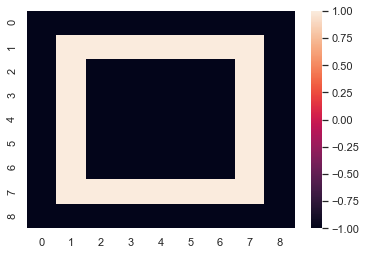

In [4]:
import numpy as np
import seaborn as sns; sns.set_theme()
b1 = sns.heatmap(bild1)

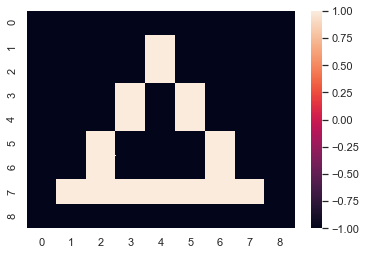

In [5]:
b2 = sns.heatmap(bild2)

In [6]:
for array in bild1:
    print(array)

[-1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, 1, 1, 1, 1, 1, 1, -1]
[-1, 1, -1, -1, -1, -1, -1, 1, -1]
[-1, 1, -1, -1, -1, -1, -1, 1, -1]
[-1, 1, -1, -1, -1, -1, -1, 1, -1]
[-1, 1, -1, -1, -1, -1, -1, 1, -1]
[-1, 1, -1, -1, -1, -1, -1, 1, -1]
[-1, 1, 1, 1, 1, 1, 1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1]


In [7]:
kernel1 = []
kernel1.append([-1, 1, -1])
kernel1.append([-1, 1, -1])
kernel1.append([1, -1, 1])
kernel1

[[-1, 1, -1], [-1, 1, -1], [1, -1, 1]]

In [8]:
kernel2= []
kernel2.append([-1, 1, -1])
kernel2.append([-1, 1, -1])
kernel2.append([1, 1, 1])
kernel2

[[-1, 1, -1], [-1, 1, -1], [1, 1, 1]]

In [9]:
kernel3 = []
kernel3.append([1, 1, 1])
kernel3.append([1, -1, -1])
kernel3.append([1, -1, -1])
kernel3

[[1, 1, 1], [1, -1, -1], [1, -1, -1]]

In [10]:
kernel4 = []
kernel4.append([1, 1, 1])
kernel4.append([-1, -1, 1])
kernel4.append([-1, -1, 1])
kernel4

[[1, 1, 1], [-1, -1, 1], [-1, -1, 1]]

In [11]:
kernel5 = []
kernel5.append([1, -1, -1])
kernel5.append([1, -1, -1])
kernel5.append([1, 1, 1])
kernel5

[[1, -1, -1], [1, -1, -1], [1, 1, 1]]

In [12]:
kernel6 = []
kernel6.append([-1, -1, 1])
kernel6.append([-1, -1, 1])
kernel6.append([1, -1, 1])
kernel6

[[-1, -1, 1], [-1, -1, 1], [1, -1, 1]]

In [13]:
bild1

[[-1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, -1, -1, -1, -1, -1, 1, -1],
 [-1, 1, 1, 1, 1, 1, 1, 1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1]]

In [14]:
    ziel = []
    ziel.append([bild1[0][0], bild1[0][1], bild1[0][2]])
    ziel.append([bild1[1][0], bild1[1][1], bild1[1][2]])
    ziel.append([bild1[2][0], bild1[2][1], bild1[2][2]])
    ziel

[[-1, -1, -1], [-1, 1, 1], [-1, 1, -1]]

In [15]:
for element in kernel1:
    print(element[0])

-1
-1
1


In [16]:
def kernel_iterate(kernel: list, bild: list):
    """kernel und bild sollten eine Liste mit weiteren Listen als Inhalt sein."""
    ergebnis = []
    ziel = []
    a = 0
    b = 0
    c = 0
    d = 1
    e = 0
    f = 2
    g = 1
    h = 0
    l = 1
    m = 1 
    n = 1
    o = 2
    p = 2
    q = 0
    r = 2
    s = 1
    t = 2
    u = 2
    ziel.append([bild[a][b], bild[c][d], bild[e][f]])
    ziel.append([bild[g][h], bild[l][m], bild[n][o]])
    ziel.append([bild[p][q], bild[r][s], bild[t][u]])
    zwischenspeicher = []
    k = 0
    i = 1
    j = 0
    y = 1
    while y < 8:
        while i < 8:
            for element in kernel:
                #print("element: " + str(element))
                #for index in ziel:
                for zahl in ziel[k]:
                    #print("j = " + str(j))
                    #print("kernel: " + str(element[j]))
                    #print("bild: " + str(zahl))
                    #print("-------------------------------")
                    #print(str(element[j]) + " * " + str(zahl))
                    
                    zwischenspeicher.append(element[j] * zahl)
                    
                    
                    j = j + 1
                    z = 0
                j = 0
                k = k + 1
            k = 0
            #print(ziel)
            #print("bild[" + str(a) + "][" + str(b) + "]" + "bild[" + str(c) + "][" + str(d) + "]" + "bild[" + str(e) + "][" + str(f) + "]")
            #print("bild[" + str(g) + "][" + str(h) + "]" + "bild[" + str(l) + "][" + str(m) + "]" + "bild[" + str(n) + "][" + str(o) + "]")
            #print("bild[" + str(p) + "][" + str(q) + "]" + "bild[" + str(r) + "][" + str(s) + "]" + "bild[" + str(t) + "][" + str(u) + "]")
                 
            for stand in zwischenspeicher:
                  z = z + stand
            print(z/9)
            ergebnis.append(z/9)

            zwischenspeicher = []
            b = b + 1
            d = d + 1
            f = f + 1
            h = h + 1
            m = m + 1
            o = o + 1
            q = q + 1
            s = s + 1
            u = u + 1
            
            if f < 9:
                ziel = []
                ziel.append([bild[a][b], bild[c][d], bild[e][f]])
                ziel.append([bild[g][h], bild[l][m], bild[n][o]])
                ziel.append([bild[p][q], bild[r][s], bild[t][u]])
           
            i = i + 1
        i = 1
        y = y + 1
        a = a + 1
        c = c + 1
        e = e + 1
        g = g + 1
        l = l + 1
        n = n + 1
        p = p + 1
        r = r + 1
        t = t + 1
        b = 0
        d = 1
        f = 2
        h = 0
        m = 1
        o = 2
        q = 0
        s = 1
        u = 2
        if p < 9:
            ziel = []
            ziel.append([bild[a][b], bild[c][d], bild[e][f]])
            ziel.append([bild[g][h], bild[l][m], bild[n][o]])
            ziel.append([bild[p][q], bild[r][s], bild[t][u]])
    return ergebnis

0.1111111111111111
0.1111111111111111
0.1111111111111111
0.1111111111111111
0.1111111111111111
0.1111111111111111
0.1111111111111111
0.1111111111111111
0.3333333333333333
-0.5555555555555556
1.0
-0.5555555555555556
0.3333333333333333
0.1111111111111111
0.1111111111111111
0.1111111111111111
-0.1111111111111111
0.3333333333333333
-0.1111111111111111
0.1111111111111111
0.1111111111111111
0.3333333333333333
-0.5555555555555556
0.7777777777777778
-0.7777777777777778
0.7777777777777778
-0.5555555555555556
0.3333333333333333
0.1111111111111111
-0.1111111111111111
0.3333333333333333
-0.3333333333333333
0.3333333333333333
-0.1111111111111111
0.1111111111111111
-0.3333333333333333
0.7777777777777778
-0.1111111111111111
0.3333333333333333
-0.1111111111111111
0.7777777777777778
-0.3333333333333333
-0.1111111111111111
0.1111111111111111
-0.3333333333333333
-0.1111111111111111
-0.3333333333333333
0.1111111111111111
-0.1111111111111111


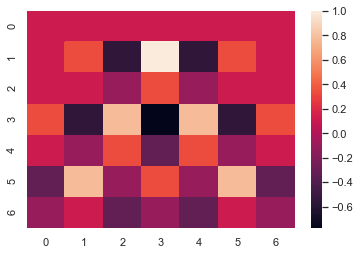

In [26]:
ergebnis = kernel_iterate(kernel1, bild2)
i = 0
a = 0
b = 7
e1heat = []
while i < 7:
    e1heat.append(ergebnis[a:b])
    a = a + 7
    b = b + 7
    i = i + 1
e1heat
e1 = sns.heatmap(e1heat)
